In [1]:
%matplotlib inline
import numpy as np  
import pandas as pd  
import seaborn as sns  
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)

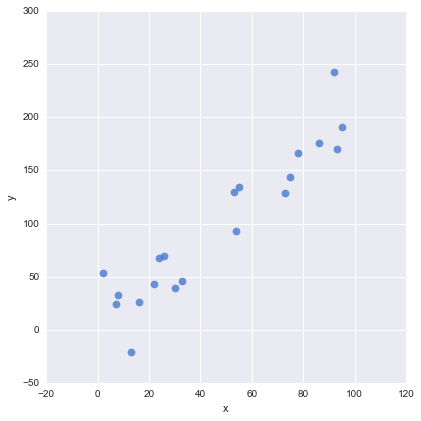

In [2]:
def generate_data(n=20, a=1, b=1, c=0, latent_error_y=10):  
    ''' 
    Create a toy dataset based on a very simple linear model 
    that we might imagine is a noisy physical process

    Model form: y ~ a + bx + cx^2 + e
    '''

    ## create linear or quadratic model
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## add latent error noise
    df['y'] += rndst.normal(0,latent_error_y,n)

    return df

df = generate_data(a=5, b=2, latent_error_y=30)

g = sns.lmplot(x='x', y='y', data=df, fit_reg=False  
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

## NOTE: `lmplot()` will fit and plot a lin. reg. line by default. 
## Not used here, but can greatly help data exploration in practice.

In [3]:
import patsy as pt  
import statsmodels.api as sm

## first, encode model specification as design matrices
fml = 'y ~ 1 + x'  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe'
                              ,NA_action='raise')

## fit OLS model and print results
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     125.2
Date:                Thu, 14 Apr 2016   Prob (F-statistic):           1.54e-09
Time:                        00:33:15   Log-Likelihood:                -92.088
No. Observations:                  20   AIC:                             188.2
Df Residuals:                      18   BIC:                             190.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.2734     10.193      0.321      0.7

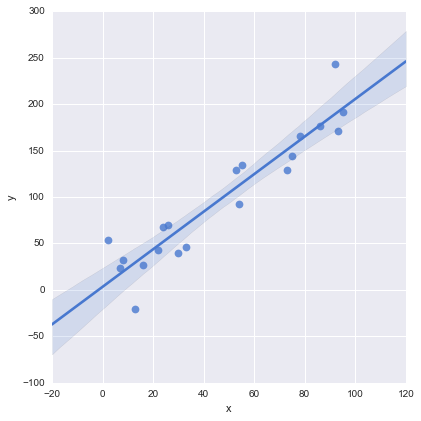

In [4]:
sns.lmplot(x='x', y='y', data=df, fit_reg=True,size=6, scatter_kws={'alpha':0.8, 's':60})

In [5]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.Normal())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN not available)


Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126ac5f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126cc42b0>]], dtype=object)

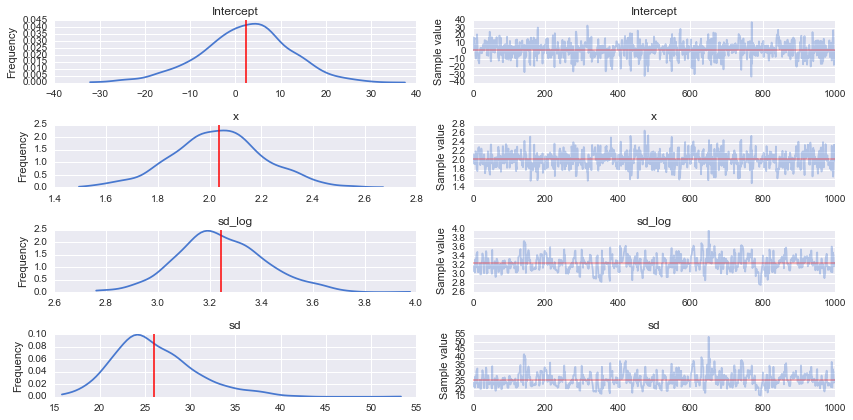

In [6]:
pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()})

In [7]:
pm.summary(trc_ols[-1000:])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.242            9.987            0.437            [-17.343, 22.392]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -18.261        -3.702         2.603          8.530          21.759


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.035            0.178            0.008            [1.666, 2.373]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.675          1.921          2.035          2.140          2.388


sd_log:

  Mean             SD               MC Error         95% HPD interval
  --------------------

In [8]:
pm.df_summary(trc_ols[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,2.242175,9.987401,0.436673,-17.343020,22.392115
x,2.034853,0.178033,0.008008,1.665582,2.372513
sd_log,3.245088,0.170280,0.010361,2.926417,3.607179
sd,26.043884,4.564029,0.276585,18.182117,36.118666


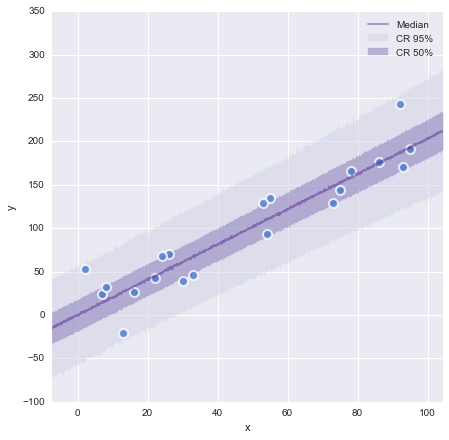

In [9]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims)

In [11]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f643240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1310a9550>]], dtype=object)

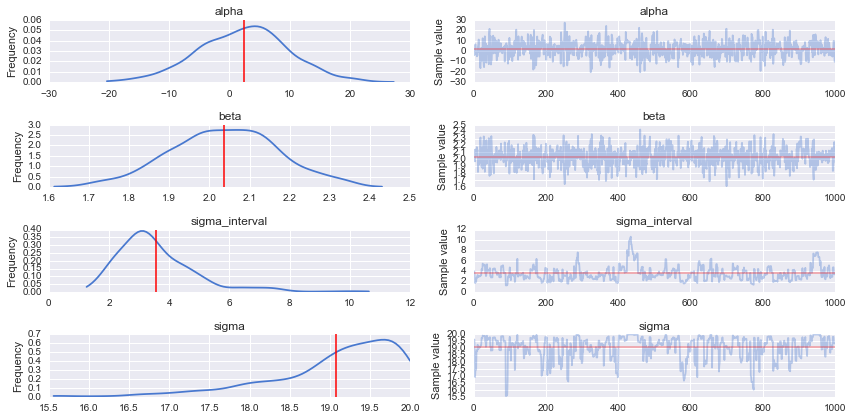

In [12]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

In [13]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.362885,7.502310,0.327949,-13.841227,15.737191
beta,2.037298,0.134623,0.005709,1.794058,2.330543
sigma_interval,3.566128,1.364007,0.112253,1.253720,6.367460
sigma,19.077853,0.806067,0.056540,17.416704,19.999517


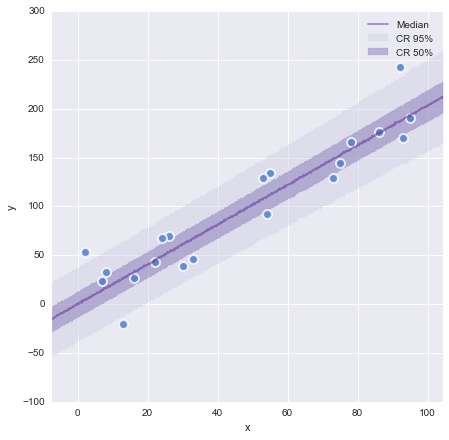

In [16]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['alpha','beta']]
    trc_sd = pm.trace_to_dataframe(trc)['sigma']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(model, trace, df, xlims)

In [19]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    mewmew = pm.Normal('mewmew', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x'] + mewmew * df['x'] * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1317f2208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12beae080>]], dtype=object)

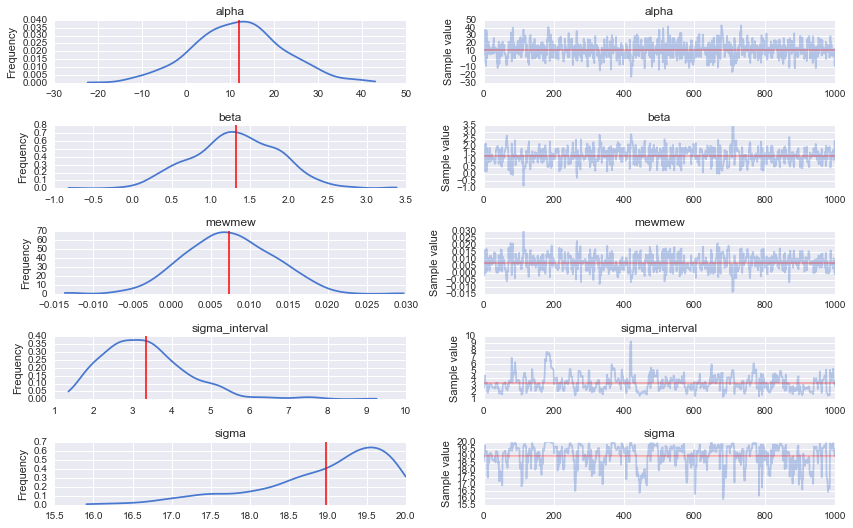

In [20]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

In [21]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,11.923543,10.331153,0.471838,-7.376733,33.388818
beta,1.323545,0.561572,0.029172,0.252416,2.306942
mewmew,0.007350,0.005705,0.000290,-0.002524,0.018803
sigma_interval,3.340597,1.142910,0.086917,1.635872,5.430480
sigma,18.972075,0.830477,0.060427,17.263416,19.998082


In [23]:
import matplotlib.pyplot as plt
import numpy as np 
def graph(formula, x_range, color='black', alpha=1):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y, color=color, alpha=alpha)

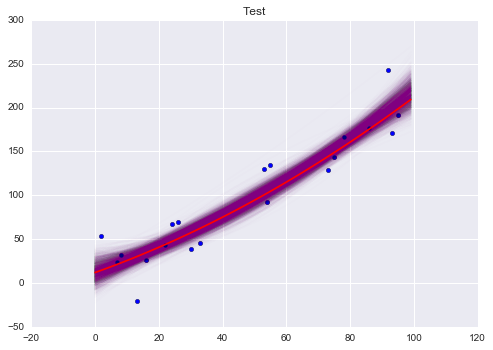

In [38]:
plt.scatter(df['x'],df['y'])

for i in range(0,2000):
    point = trace.point(i)
    graph('{0} + {1}*x + {2}*x*x'.format(point['alpha'], point['beta'], point['mewmew']), range(0,100), color='purple', alpha=.00908035)

graph('11.9 + 1.3*x + .007*x*x', range(0,100), color='red', alpha=1)
plt.title('Test')
plt.show()
